1849-01-01
What are the unique cities
100
how many records
239177
['1849-01-01' 26.704 1.435 5.63 -3.23]
The following values are for  Abidjan
The following values are for  Addis Abeba
The following values are for  Ahmadabad
The following values are for  Aleppo
The following values are for  Alexandria
The following values are for  Ankara
The following values are for  Baghdad
The following values are for  Bangalore
The following values are for  Bangkok
The following values are for  Belo Horizonte
The following values are for  Berlin
The following values are for  BogotÃ¡
The following values are for  Bombay
The following values are for  BrasÃ­lia
The following values are for  Cairo
The following values are for  Calcutta
The following values are for  Cali
The following values are for  Cape Town


C:\Users\Owner\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The following values are for  Casablanca
The following values are for  Changchun
The following values are for  Chengdu
The following values are for  Chicago
The following values are for  Chongqing
The following values are for  Dakar
The following values are for  Dalian
The following values are for  Dar Es Salaam
The following values are for  Delhi
The following values are for  Dhaka
The following values are for  Durban
The following values are for  Faisalabad
The following values are for  Fortaleza
The following values are for  Gizeh
The following values are for  Guangzhou
The following values are for  Harare
The following values are for  Harbin
The following values are for  Ho Chi Minh City
The following values are for  Hyderabad
The following values are for  Ibadan
The following values are for  Istanbul
The following values are for  Izmir
The following values are for  Jaipur
The following values are for  Jakarta
The following values are for  Jiddah
The following values are for  Jinan

C:\Users\Owner\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The following values are for  Montreal
The following values are for  Moscow
The following values are for  Nagoya
The following values are for  Nagpur
The following values are for  Nairobi
The following values are for  Nanjing
The following values are for  New Delhi
The following values are for  New York
The following values are for  Paris
The following values are for  Peking
The following values are for  Pune
The following values are for  Rangoon
The following values are for  Rio De Janeiro
The following values are for  Riyadh
The following values are for  Rome
The following values are for  SÃ£o Paulo
The following values are for  Saint Petersburg
The following values are for  Salvador
The following values are for  Santiago
The following values are for  Santo Domingo
The following values are for  Seoul
The following values are for  Shanghai
The following values are for  Shenyang
The following values are for  Singapore
The following values are for  Surabaya
The following values are for 

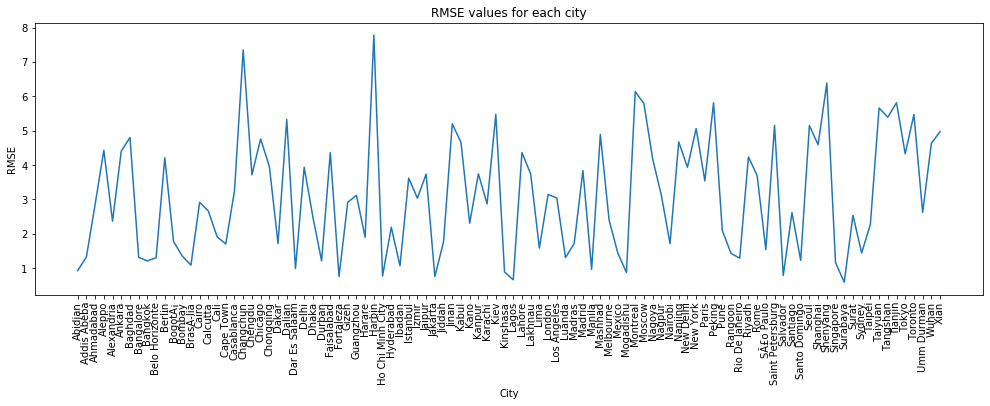

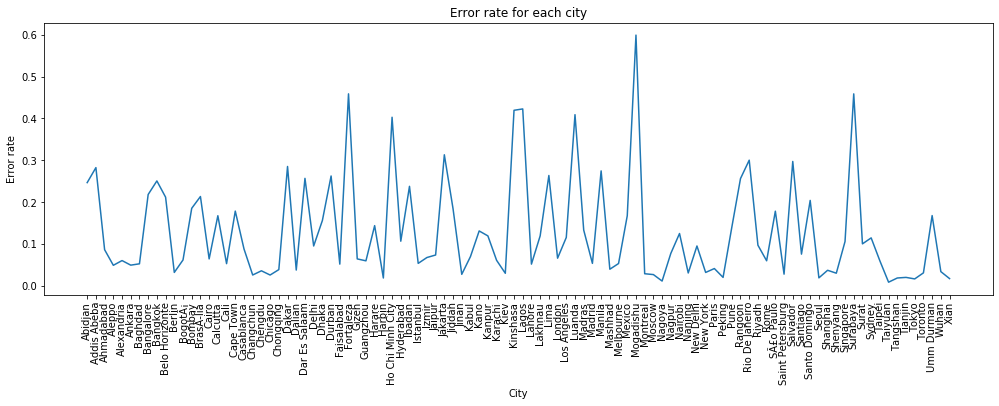

In [8]:
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import scipy
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

def main():

    #Read in data
    data = pd.read_csv("GlobalLandTemperaturesByMajorCity.csv",delimiter=",", encoding='latin-1')

    
    cityNum = len(data.City.unique())
    cities = data.City.unique()
    new_data_np = long_lat_encoding(data.to_numpy())
    new_data = np.delete(new_data_np, np.s_[3:5], axis=1)
    
    
    
    print(new_data[0])

    startIndex = 0 
    rmseVals = []
    errorVals = []
    #loop to calculate rmse and accuracy for each city
    for i in range(cityNum):
        print("The following values are for ", cities[i])
        xVals, yVals, standDevs, startIndex = x_and_y_vals_per_city(new_data, startIndex)
        xtrain, ytrain, xtest, ytest, standtrain, standtest = train_test_split(xVals, yVals, standDevs)
        rmse, error = sarima(xtrain, ytrain, xtest, ytest, standtrain, standtest)
        rmseVals.append(rmse)
        errorVals.append(error)
    
    print("All rmse values ", rmseVals)
    print("All errorVals ", errorVals)
    
    avg_rmse = sum(rmseVals) / len(rmseVals)
    avg_error = sum(errorVals) / len(errorVals)
    
    print("Average rmse ", avg_rmse)
    print("Average error rate ", avg_error)
    line_graph_ticks(cities, rmseVals, "RMSE values for each city", "City", "RMSE")
    
    line_graph_ticks(cities, errorVals, "Error rate for each city", "City", "Error rate")
    
def sarima(xtrain, ytrain, xtest, ytest, standtrain, standtest):
    
    
    #fit model for my data
    model = SARIMAX(ytrain, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    
    #Predict temp values
    start = len(xtrain) + 1
    end = start + len(xtest) - 1
    yPredict = model_fit.predict(start=start, end=end, dynamic=False)
    
     
    #Remove nan data entries in both ytest, yPredict, and standDevs to not get errors in mean_squared_error 
    ytest_without_nan = []
    yPredict_without_nan = []
    standtest_without_nan = []
    for i in range(len(ytest)):
        if(str(ytest[i]) != 'nan'):
            ytest_without_nan.append(ytest[i])
            yPredict_without_nan.append(yPredict[i])
            standtest_without_nan.append(standtest[i])
            
    otherrmse = mean_squared_error(ytest_without_nan, yPredict_without_nan)
    otherrmse = np.sqrt(otherrmse)
    
    #Calculate error rate using average temperature uncertainty from dataset
    errorRate = error_rate(ytest_without_nan, yPredict_without_nan, standtest_without_nan)
    
    return otherrmse, errorRate
    
def error_rate(yTrue, yPredict, standDevs):    
    #should this be computed on training and test data?
    correct = 0
    
    for i in range(len(yTrue)):
        #Create range of acceptable temperatures
        low = float(yTrue[i]) - float(standDevs[i])
        high = float(yTrue[i]) + float(standDevs[i])
        
        #Check if predicted value is in the range
        if(yPredict[i] > low and yPredict[i] < high):
            correct += 1
            
    #Calculate error rate
    rate = correct / len(yPredict)
    
    return rate
    
    
def x_and_y_vals_per_city(new_data, startIndex):
    #Returns the dates, average teperatures and average temperature uncertainty for the city 
    #corresponding to the index passed in
    
    x_vals_per_city = []
    y_vals_per_city = []
    stand_devs_per_city = []

    #Establish variables for that city
    i = startIndex
    lat = new_data[i][3]
    long = new_data[i][4]
    end = True
    
    #Only loop till you are not on the same city
    while( end == True and i != len(new_data)):
        if(new_data[i][3] == lat and new_data[i][4] == long):
            x_vals_per_city.append(new_data[i][0])
            y_vals_per_city.append(new_data[i][1])
            stand_devs_per_city.append(new_data[i][2])
            i += 1
            
        else:
            end = False
        
    return x_vals_per_city, y_vals_per_city, stand_devs_per_city, i
   
def line_graph_ticks(x, y, title, xLabel, yLabel):
    plt.rcParams['figure.figsize'] = [17, 5]
    
    nums = list(range(100))   
    x_nums = np.array(nums)
    
    my_xticks = list(x)
    plt.xticks(x_nums, my_xticks)
    plt.xticks(rotation=90)
    plt.plot(x_nums, y)
    
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.show()
    
def line_graph(x, y, title, xLabel, yLabel):
    plt.rcParams['figure.figsize'] = [10, 5]
    
    #Graphing
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.show()
   
def train_test_split(x_vals, y_vals, stand_devs):
    #Calculate train and test split
    #70% for train 30% for test
    val = len(x_vals) * .7
    
    #Round to nearest multiple of 12
    index = int(12 * round(float(val)/12))
    
    
    xtrain = x_vals[:index]
    ytrain = y_vals[:index]
    standtrain = stand_devs[:index]
    
    xtest = x_vals[index:]
    ytest = y_vals[index:]
    standtest = stand_devs[index:]
    
    
    return xtrain, ytrain, xtest, ytest, standtrain, standtest
    

def long_lat_encoding(data):
    #This function simply makes all south and west longitude and latitiude values negative

    for i in range(len(data)):

        #Make it negative if south otherwise just make it a float
        if("S" in data[i][5]):
            lat_string = data[i][5].replace("S", "")
            data[i][5] = float(lat_string) * -1
        else:
            lat_string = data[i][5].replace("N", "")
            data[i][5] = float(lat_string)

        if("W" in data[i][6]):
            long_string = data[i][6].replace("W", "")
            data[i][6] = float(long_string) * -1
        else:
            long_string = data[i][6].replace("E", "")
            data[i][6] = float(long_string)

    return data

main()